# Density-Based Clustering 
Divides dataset into dense regions separated by sparse regions. Focuses on finding clusters of nodes that exhibit high internal density in terms of attribute similarity.

- DBSCAN: Density-Based Spatial Clustering of Applications with Noise
- OPTICS: Ordering Points To Identify the Clustering Structure

Unlike k-means, DBSCAN can identify nested clusters and outliers. 
### Hyperparameters 
- MinPts: min number of points required to form a dense region = cluster
- Epsilon: radius of the neighbourhood around a given a data point (i.e. max distance between 2 points for them to be considered the same cluster)

### Types of points
1. Core points: there are at least MinPts data points within epsilon-distance, including itself. (multiple core points can be in 1 cluster)
2. Border points: within epsilon distance of a Core Point - form boundaries of clusters
3. Noise points (outliers): remaining points; beyond the epsilon-distance of a border point - do not belong to any cluster

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [20]:
# pip install kneed
# pip install hdbscan

In [21]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

from sklearn.datasets import make_blobs
from sklearn import metrics
from sklearn.cluster import DBSCAN

In [22]:
df = pd.read_csv("cleaned_data.csv")
print(df.shape)
df.head()

(529, 44)


,PCOS (Y/N),Age (yrs),BMI,Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Menstrual Cycle Length(days),Marriage Status (Yrs),Pregnant(Y/N),No. of abortions,...,Blood Group_A+,Blood Group_A-,Blood Group_AB+,Blood Group_AB-,Blood Group_B+,Blood Group_B-,Blood Group_O+,Blood Group_O-,Menstrual Cycle(R/I)_irregular,Menstrual Cycle(R/I)_regular
0,0,28,19.3,78,22,10.48,5,7.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0,36,24.9,74,20,11.70,5,11.0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1,33,25.3,72,18,11.80,5,10.0,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,37,29.7,72,20,12.00,5,4.0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0,25,20.1,72,18,10.00,5,1.0,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Data Preparation

In [23]:
X = df.drop(['PCOS (Y/N)'], axis=1) 
y = df['PCOS (Y/N)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Standardisation - StandardScalar


In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Handling Class Imbalance - Upsampling with SMOTE

In [25]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

## Modelling
### Choosing optimal parameters

1. epsilon
- larger = lesser clusters
- use kNN - elbow point

k is selected to be: 87


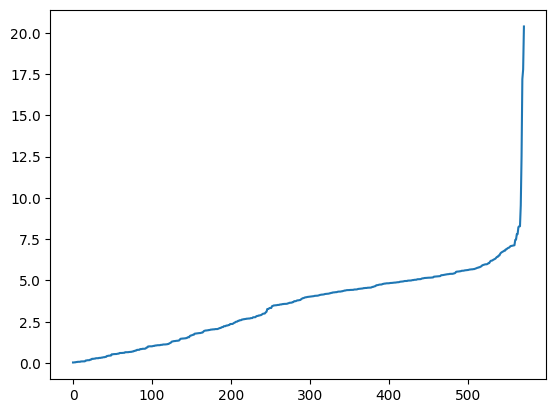

In [26]:
dim = df.shape[1]
k = 2 * dim - 1
print("k is selected to be:", k)
neighbours = NearestNeighbors(n_neighbors = 2).fit(X_train)
distances, indices = neighbours.kneighbors(X_train)
distances = np.sort(distances[:,1])
plt.plot(distances)

Optimal epsilon:  7.805759511227579


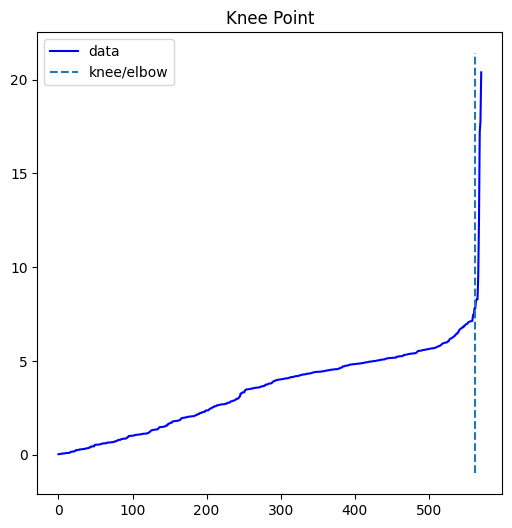

In [27]:
kneedle = KneeLocator(range(len(distances)), distances, S=1.0, curve="convex", direction="increasing")
optimal_epsilon = distances[kneedle.knee]
print("Optimal epsilon: ", optimal_epsilon)

kneedle.plot_knee()
plt.show()

2. MinPts
- larger = lesser clusters
- guideline 1: dimensionality+1
- guideline 2: 2*d (reason: as the dimensionality of the data increases, density decreases -> more difficult to identify meaningful clusters. setting as a higher value in high-dimensional datasets -> ensure clusters are more robust and have a higher level of statistical significance.)

- _after trying, guideline 1 performs better_

In [28]:
min_samples = 2 * dim
min_samples

88

### DBSCAN Clustering

In [29]:
db = DBSCAN(eps = optimal_epsilon, min_samples = 15).fit(X)
y_pred = db.fit_predict(X_train)


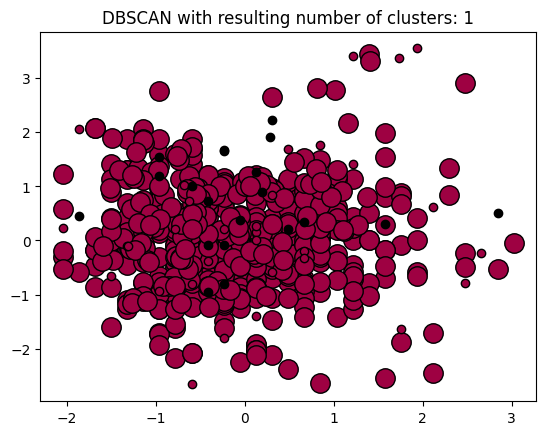

Estimated number of clusters: 1
Estimated number of noise points: 19
Homogeneity: 0.002
Completeness: 0.008
V-measure: 0.003
Silhouette Coefficient: 0.385


In [30]:
# count vars
labels_pred = db.labels_
n_clusters_ = len(set(labels_pred)) - (1 if -1 in labels_pred else 0)
n_noise_ = list(labels_pred).count(-1)

# use this to separate Noise and non-noise Pts into a True/ False array so we can use it later for plotting
core_samples_mask = np.zeros_like(labels_pred, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

# change color scale 
unique_labels = set(labels_pred)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]
    class_member_mask = labels_pred == k

    # plot Core and Border pts only 
    xy = X_train[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], "o", markerfacecolor=tuple(col), markeredgecolor="k", markersize=14)

    # plot Noise pts only
    xy = X_train[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], "o", markerfacecolor=tuple(col), markeredgecolor="k", markersize=6)

plt.title(f"DBSCAN with resulting number of clusters: {n_clusters_}")
plt.show()

# results 
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print(f"Homogeneity: {metrics.homogeneity_score(y_train, labels_pred):.3f}")
print(f"Completeness: {metrics.completeness_score(y_train, labels_pred):.3f}")
print(f"V-measure: {metrics.v_measure_score(y_train, labels_pred):.3f}")
print(f"Silhouette Coefficient: {metrics.silhouette_score(X_train, labels_pred):.3f}")

# better silhouette score = better (> 0.5 is good)

### Evaluation

In [31]:
# pip install permetrics

In [32]:
from permetrics import ClusteringMetric
cm = ClusteringMetric(X=X_train, y_pred=y_pred)

print(cm.density_based_clustering_validation_index())
print(cm.DBCVI())

nan
nan


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [33]:
from DBCV import DBCV 
import hdbscan
from scipy.spatial.distance import euclidean
dbscan_score = DBCV(X_train, y_pred, dist_function=euclidean)

ModuleNotFoundError: No module named 'DBCV'

k-fold CV

(Recursive Feature Engineering)

Hyperparameter Tuning


**References**

basic overview: https://medium.com/@sachinsoni600517/clustering-like-a-pro-a-beginners-guide-to-dbscan-6c8274c362c4

implementing dbscan & knn:
https://blog.deepsim.xyz/dbscan-clustering-python-real-world-data/#4.3-Select-features